# Stage 6: Train XGBoost (GPU)

In [1]:
from datetime import datetime
import pickle

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import humanize
import numpy as np
import pandas as pd
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot

%matplotlib inline
%load_ext autoreload

In [2]:
encoder = LabelEncoder()

# features = pickle.load(open('./data/stage4-l_encoded-oversampled.pkl', 'rb'))
# labels = encoder.fit_transform(features.pop('stop_outcome'))

X_train = pickle.load(open('./data/stage6-train.pkl', 'rb'))
# y_train = encoder.fit_transform(X_train.pop('stop_outcome'))
y_train = X_train.pop('stop_outcome')
X_test = pickle.load(open('./data/stage6-test.pkl', 'rb'))
# y_test = encoder.fit_transform(X_test.pop('stop_outcome'))
y_test = X_test.pop('stop_outcome')

print('Row counts:\n\ttrain: {}\n\ttest: {}'.format(X_train.shape[0], X_test.shape[0]))


Row counts:
	train: 250247
	test: 62562


In [3]:
# Take out 5% of data for final final testing; shuffle first
# lop_off_pct = .20
# lop_off_idx = round(features.shape[0] * lop_off_pct)
# print('lop_off_idx = {}'.format(lop_off_idx))

# final_test_features = features[:lop_off_idx]
# final_test_outcomes = labels[:lop_off_idx]

# features = features[lop_off_idx:]
# labels = labels[lop_off_idx:]

In [4]:
# Take out 5% of data for final final testing; shuffle first
# final_test_features = pickle.load(open('./data/final_test_set.pkl', 'rb'))
# final_test_outcomes = encoder.fit_transform(final_test_features.pop('stop_outcome'))
# print('Final test set row count: {}'.format(final_test_features.shape[0]))

In [5]:
# Split the 'features' and 'labels' data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features,
#                                                     labels, 
#                                                     test_size=0.2, 
#                                                     random_state=0)
# X_train = features
# y_train = labels
# X_test = final_test_features
# y_test = final_test_outcomes


In [6]:
xg_train = xgb.DMatrix(X_train.values, label=y_train)
xg_test = xgb.DMatrix(X_test.values, label=y_test)
# xg_test_2 = xgb.DMatrix(final_test_features.values, label=final_test_outcomes)

## Non-tuned hyperparameters

In [7]:
params = {
    'objective': 'multi:softmax',
#     'learning_rate': 0.0983,
#     'max_depth': 19,
    'num_class': 6,
    'silent': 0,
    'nthread': 8,
    'tree_method': 'gpu_hist',
#     'subsample': 0.9,
}


In [8]:
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 10000
# num_round = 5

bst = xgb.train(params=params, dtrain=xg_train, num_boost_round=num_round, evals=watchlist, early_stopping_rounds=50)
# bst = xgb.train(params=params, dtrain=xg_train, num_boost_round=num_round, evals=watchlist)

[0]	train-merror:0.272039	test-merror:0.279467
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 50 rounds.
[1]	train-merror:0.271979	test-merror:0.283511
[2]	train-merror:0.271843	test-merror:0.282152
[3]	train-merror:0.271624	test-merror:0.282456
[4]	train-merror:0.271532	test-merror:0.281721
[5]	train-merror:0.271044	test-merror:0.281577
[6]	train-merror:0.270545	test-merror:0.280266
[7]	train-merror:0.270269	test-merror:0.280186
[8]	train-merror:0.269102	test-merror:0.279307
[9]	train-merror:0.268683	test-merror:0.279003
[10]	train-merror:0.267879	test-merror:0.278508
[11]	train-merror:0.267224	test-merror:0.277772
[12]	train-merror:0.266681	test-merror:0.277437
[13]	train-merror:0.265945	test-merror:0.277021
[14]	train-merror:0.26543	test-merror:0.277053
[15]	train-merror:0.264171	test-merror:0.276622
[16]	train-merror:0.263612	test-merror:0.276318
[17]	train-merror:0.263096	test-merror:0.276126


In [9]:
pickle.dump(bst, open('runs/bst-nontuned.pkl', 'wb'))

## Tuned hyperparameters

In [10]:
params = {
    'objective': 'multi:softmax',
    'learning_rate': 0.0983,
    'max_depth': 19,
    'silent': 0,
    'nthread': 8,
#     'num_class': 45,
#     'predictor': 'gpu_predictor',
#     'max_bin': 512,
    'tree_method': 'gpu_hist',
#     'alpha': 0.8,
#     'gamma': 10.0,
    'subsample': 0.9,
#     'lambda': 0.9,,
#     'colsample_bytree': 0.9,
#     'colsample_bylevel': 0.3,
#     'scale_pos_weight': 0.1,
#     'updater': 'grow_histmaker,refresh,prune',
#     'grow_policy': 'lossguide',
#     'max_leaves': 20000,
#     'max_bin': 1024,
#     'base_score': 1.0,
#     'eval_metric': 'merror',
#     'max_delta_step': 8,
}

params['num_class'] = len(list(X_train.columns.values))

# model = XGBClassifier(xgb_params)
# num_rounds = 3
# model = xgb.train(xgb_params, xg_train, num_rounds)

# n_estimators = [500, 1500, 2500]
# max_depth = [5, 12, 19]
# n_estimators = [5, 10]
# max_depth = [2]

# param_grid = {
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
# }
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [11]:
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 10000
# num_round = 5

bst = xgb.train(params=params, dtrain=xg_train, num_boost_round=num_round, evals=watchlist, early_stopping_rounds=150)
# bst = xgb.train(params=params, dtrain=xg_train, num_boost_round=num_round, evals=watchlist)

[0]	train-merror:0.255663	test-merror:0.277069
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 150 rounds.
[1]	train-merror:0.248558	test-merror:0.276174
[2]	train-merror:0.241469	test-merror:0.275519
[3]	train-merror:0.235395	test-merror:0.275471
[4]	train-merror:0.230077	test-merror:0.275455
[5]	train-merror:0.224878	test-merror:0.275407
[6]	train-merror:0.219959	test-merror:0.274911
[7]	train-merror:0.2147	test-merror:0.275327
[8]	train-merror:0.21064	test-merror:0.275055
[9]	train-merror:0.206148	test-merror:0.275375
[10]	train-merror:0.202092	test-merror:0.275455
[11]	train-merror:0.19788	test-merror:0.276046
[12]	train-merror:0.194264	test-merror:0.275822
[13]	train-merror:0.191035	test-merror:0.27587
[14]	train-merror:0.187735	test-merror:0.276046
[15]	train-merror:0.18441	test-merror:0.276046
[16]	train-merror:0.181309	test-merror:0.276382
[17]	train-merror:0.177844	test-merror:0.276526
[18]

In [12]:
pickle.dump(bst, open('runs/bst-tuned.pkl', 'wb'))

In [13]:
pred = bst.predict(xg_test)

In [14]:
error_rate = np.sum(pred != y_test) / y_test.shape[0]
print('Test error = {}'.format(error_rate))

Test error = 0.2842140596528244


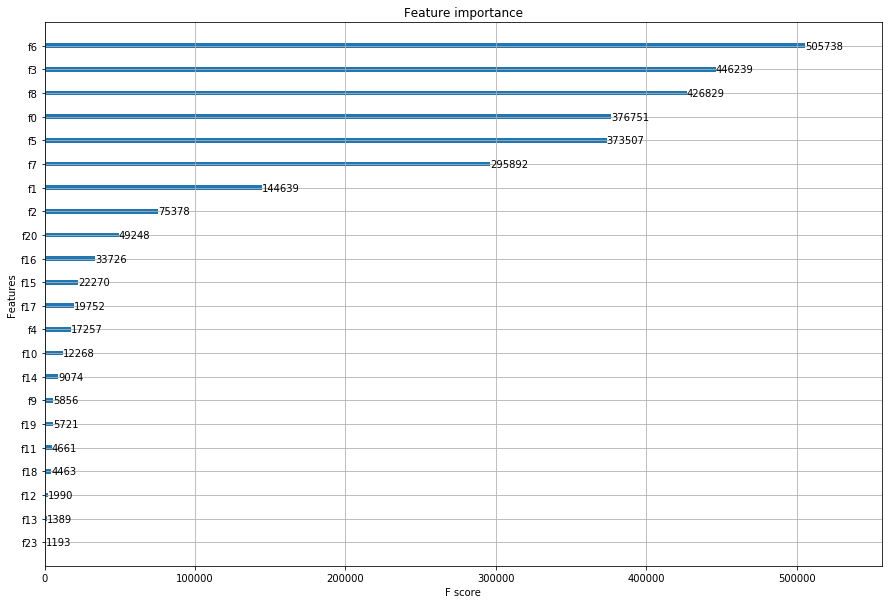

In [15]:
ax = xgb.plot_importance(bst)
fig = ax.figure
fig.set_size_inches(15, 10)

In [16]:
for idx, c in enumerate(X_train.columns.values):
    print('{}: {}'.format(idx, c))

0: location_raw
1: county_name
2: driver_gender
3: driver_age_raw
4: stop_duration
5: hour
6: minute
7: month
8: day
9: violation_bad_stop
10: violation_cell_phone
11: violation_display_of_plates
12: violation_equipment
13: violation_license
14: violation_lights
15: violation_moving_violation
16: violation_other
17: violation_registration
18: violation_safe_movement
19: violation_seatbelt
20: violation_speeding
21: violation_suspended_license
22: violation_traffic_control_signal
23: violation_window_tint


In [17]:
# pred_2 = bst.predict(xg_test_2)

In [18]:
# error_rate = np.sum(pred_2 != encoder.fit_transform(final_test_outcomes)) / final_test_outcomes.shape[0]
# print('Test error [test_2] = {}'.format(error_rate))

### Plot results

In [19]:
# error_results = {
#     'train': [],
#     'test': [],
# }

# with open('xgboost-447_run-201805100107.log', 'r') as f:
#     for line in f:
#         tokens = line.strip().split('\t')
#         error_results['train'].append(float(tokens[1].split(':')[1]))
#         error_results['test'].append(float(tokens[2].split(':')[1]))

# df_errors = pd.DataFrame(error_results)

# learning_curve = df_errors.plot.line(title='Learning curve', figsize=(8,5))
# learning_curve.set_xlabel('Number of runs')
# learning_curve.set_ylabel('Error')

In [20]:
# df_accuracy = df_errors.copy()
# df_accuracy_processed = df_accuracy.mul(-1).add(1)

# learning_curve = df_accuracy_processed.plot.line(title='Learning curve', figsize=(8,5))
# learning_curve.set_xlabel('Number of runs')
# learning_curve.set_ylabel('Accuracy')

In [21]:
# final_model = final_features.copy(deep=True)
# final_model['stop_outcome'] = outcomes
# final_model.to_csv('runs/201805100107-0.062-error-final_model.csv')

# History

| Stage | Non-Tuned | Tuned Error |
|:-----:|:------:|:------:|
|   1   | | 0.4939 |
|   2   | 0.2821 | 0.2967 |
|   3   | 0.2821 | 0.2992 |
|   4   |  | 0.3894 |
